In [116]:
from pathlib import Path
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.io as pio
import plotly.colors
import numpy as np
import scipy
import sklearn.decomposition
import copy
import paretoset

In [117]:
pio.templates["matplotlib"] = copy.deepcopy(pio.templates["plotly_white"])
pio.templates.default = "matplotlib"
pio.templates["matplotlib"]["layout"]["xaxis"]["showline"] = True
pio.templates["matplotlib"]["layout"]["xaxis"]["linecolor"] = "black"
pio.templates["matplotlib"]["layout"]["yaxis"]["showline"] = True
pio.templates["matplotlib"]["layout"]["yaxis"]["linecolor"] = "black"
pio.templates["matplotlib"]["layout"]["colorway"] = plotly.colors.qualitative.T10

In [118]:
csv_files = {x.stem: x for x in (Path("../data").glob("*.csv"))}

In [119]:
# all_results_df = pd.read_csv(csv_files["all_results"])
all_results_df = pd.read_csv(csv_files["full_data_pepr"])
all_results_df.columns

Index(['model', 'num_param', 'memT', 'memR', 'memA', 'memM', 'energy', 'co2',
       'train_time', 'infer_time', 'test_00', 'inf_time', 'tr_acc', 'test_01',
       'test_02', 'test_03', 'test_04', 'test_05', 'test_06', 'test_07',
       'test_08', 'test_09', 'pretrain', 'type', 'efficient', 'dataset', 'pen',
       'conv_idx', 'best_test', 'energy_conv', 'time_conv', 'co2_conv', 'E_n',
       'pepr_e', 'C_n', 'pepr_c', 'T_n', 'pepr_t', 'pepr_m', 'cnn', 'pepr_t`'],
      dtype='object')

In [120]:
all_results_df["dataset"].unique().tolist()

['derma_pt', 'lidc', 'derma', 'pneumonia']

In [121]:
model_columns = ["model", "num_param", "type", "efficient"]
model_df = all_results_df[model_columns].drop_duplicates().reset_index(drop=True)
model_df

model  num_param   type  efficient
0           dla46x_c    1068440    CNN          0
1            dla46_c    1301400    CNN          0
2    mobilevitv2_050    1370593  Other          1
3    mobilenetv2_050    1968680    CNN          1
4      semnasnet_075    2912278  Other          1
..               ...        ...    ...        ...
126    ecaresnet269d  102093077  Other          1
127  legacy_senet154  115088984    CNN          0
128      resnetrs270  129861448    CNN          0
129            vgg11  132863336    CNN          0
130            vgg13  133047848    CNN          0

[131 rows x 4 columns]

In [122]:
dataset_columns = ["dataset"]
dataset_df = all_results_df[dataset_columns].drop_duplicates()
dataset_df = dataset_df.reset_index(drop=True)
dataset_df["small"] = [x.endswith("small") for x in dataset_df["dataset"]]
dataset_df["pretrain"] = [x != "derma" for x in dataset_df["dataset"]]
dataset_df

dataset  small  pretrain
0   derma_pt  False      True
1       lidc  False      True
2      derma  False     False
3  pneumonia  False      True

In [123]:
# dataset_prefix = "derma"
# idx = (all_results_df["dataset"] == "derma_small") | (all_results_df["dataset"] == "derma_pt")
# idx = (all_results_df["dataset"] == "derma_small")
# dataset_prefix = "derma_pt"
# dataset_prefix = "lidc"
# dataset_prefix = "pneumonia"
# idx = (all_results_df["dataset"] == f"{dataset_prefix}_small") | (all_results_df["dataset"] == f"{dataset_prefix}")
# idx = (all_results_df["dataset"] == f"{dataset_prefix}")
# dataset_prefix = "all_large"
# idx = (all_results_df["dataset"] == f"derma_pt") | (all_results_df["dataset"] == f"lidc") | (all_results_df["dataset"] == f"pneumonia")
# idx = (all_results_df["dataset"] == "derma_small") | (all_results_df["dataset"] == "derma")
# idx = (all_results_df["dataset"] == "pneumonia_small") | (all_results_df["dataset"] == "pneumonia")
# df = pd.DataFrame(all_results_df[idx])
df = pd.DataFrame(all_results_df)
df = df.sort_values(["dataset", "num_param"])
df["label"] = [f"{x.model} {x.dataset}" for x in df.itertuples()]
df["dataset"].unique()

array(['derma', 'derma_pt', 'lidc', 'pneumonia'], dtype=object)

In [124]:
df["test_profile"] = df[[f"test_{i:02d}" for i in range(10)]].values.tolist()

In [125]:
test_profile = np.array(df["test_profile"].tolist())

In [126]:
peak_profile = np.zeros_like(test_profile)
peak_profile[:, 0] = test_profile[:, 0]
for i in range(1, peak_profile.shape[-1]):
    peak_profile[:, i] = np.maximum(peak_profile[:, i-1], test_profile[:, i])
peak_profile

array([[0.66129032, 0.66129032, 0.66280242, ..., 0.72278226, 0.73185484,
        0.73185484],
       [0.59828629, 0.66733871, 0.66733871, ..., 0.7172379 , 0.7172379 ,
        0.7172379 ],
       [0.66481855, 0.69707661, 0.70766129, ..., 0.70766129, 0.70766129,
        0.70766129],
       ...,
       [0.83881579, 0.875     , 0.91611842, ..., 0.95723684, 0.95723684,
        0.95723684],
       [0.92927632, 0.92927632, 0.94243421, ..., 0.94243421, 0.94243421,
        0.94243421],
       [0.91940789, 0.91940789, 0.91940789, ..., 0.91940789, 0.91940789,
        0.91940789]])

In [127]:
df["peak_profile"] = peak_profile.tolist()

In [128]:
df["peak_test"] = peak_profile[:, -1]

In [129]:
df[["peak_test", "best_test"]]

peak_test  best_test
262   0.731855   0.731855
263   0.717238   0.717238
264   0.707661   0.707661
265   0.684476   0.684476
266   0.708669   0.708669
..         ...        ...
519   0.947368   0.947368
520   0.970395   0.970395
521   0.957237   0.957237
522   0.942434   0.942434
523   0.919408   0.919408

[524 rows x 2 columns]

In [130]:
dataset_max_test = df.groupby("dataset")[["peak_test"]].max().rename(columns={"peak_test": "dataset_peak_test"}).reset_index()
dataset_max_test

dataset  dataset_peak_test
0      derma           0.771169
1   derma_pt           0.878528
2       lidc           0.713431
3  pneumonia           0.972039

In [131]:
df["dataset_peak_test"] = pd.merge(df[["dataset"]], dataset_max_test, on="dataset", how="left")["dataset_peak_test"].values
df

model  num_param       memT       memR      memA       memM  \
262         dla46x_c    1068440  25.435111   3.001025  0.038321   2.267537   
263          dla46_c    1301400  25.435111   2.520777  0.042073   1.882373   
264  mobilevitv2_050    1370593  25.435111   3.091202  0.060189   2.885807   
265  mobilenetv2_050    1968680  25.435111   2.227175  0.053616   1.934997   
266    semnasnet_075    2912278  25.435111   2.791309  0.068774   2.116848   
..               ...        ...        ...        ...       ...        ...   
519    ecaresnet269d  102093077  25.435111  19.709034  1.626204  19.053249   
520  legacy_senet154  115088984  25.435111  17.882415  1.830368  16.580966   
521      resnetrs270  129861448  25.435111  20.937966  2.071346  20.111435   
522            vgg11  132863336  25.435111   6.327108  2.082335   4.486133   
523            vgg13  133047848  25.435111   7.402947  2.085288   5.292606   

       energy       co2  train_time  infer_time  ...       T_n    pepr_t  \
262  0.018471  0.969729   11.889799           0  ...  0.004508  0.725236   
263  0.016436  1.536767   10.464308           0  ...  0.008292  0.706851   
264  0.015261  1.434517    9.933567           0  ...  0.014266  0.691424   
265  0.010583  1.010668    7.320693           0  ...  0.001620  0.681154   
266  0.014516  1.386263    9.723404           0  ...  0.003990  0.702792   
..        ...       ...         ...         ...  ...       ...       ...   
519  0.110504  6.354000   67.245142           0  ...  0.052982  0.876823   
520  0.117932  6.781100   71.897292           0  ...  0.174289  0.770791   
521  0.114794  6.543268   69.961452           0  ...  0.083787  0.850284   
522  0.028799  1.569527   18.067179           0  ...  0.027559  0.903541   
523  0.040320  2.157115   25.157074           0  ...  0.121377  0.778434   

       pepr_m    cnn   pepr_t`                      label  \
262  0.685726   True  0.728570             dla46x_c derma   
263  0.686539   True  0.711339              dla46_c derma   
264  0.660436  False  0.697708      mobilevitv2_050 derma   
265  0.663942   True  0.683369      mobilenetv2_050 derma   
266  0.670186  False  0.705853        semnasnet_075 derma   
..        ...    ...       ...                        ...   
519  0.511548  False  0.899701    ecaresnet269d pneumonia   
520  0.549432   True  0.826368  legacy_senet154 pneumonia   
521  0.501255   True  0.883233      resnetrs270 pneumonia   
522  0.770289   True  0.917158            vgg11 pneumonia   
523  0.721666   True  0.819892            vgg13 pneumonia   

                                          test_profile  \
262  [0.6612903225806451, 0.6285282258064516, 0.662...   
263  [0.5982862903225806, 0.6673387096774194, 0.657...   
264  [0.6648185483870968, 0.6970766129032258, 0.707...   
265  [0.6723790322580645, 0.6512096774193549, 0.669...   
266  [0.655241935483871, 0.6844758064516129, 0.6915...   
..                                                 ...   
519  [0.837171052631579, 0.8519736842105263, 0.9375...   
520  [0.8717105263157895, 0.9703947368421052, 0.888...   
521  [0.8388157894736842, 0.875, 0.9161184210526316...   
522  [0.9292763157894736, 0.912828947368421, 0.9424...   
523  [0.919407894736842, 0.9177631578947368, 0.8930...   

                                          peak_profile  peak_test  \
262  [0.6612903225806451, 0.6612903225806451, 0.662...   0.731855   
263  [0.5982862903225806, 0.6673387096774194, 0.667...   0.717238   
264  [0.6648185483870968, 0.6970766129032258, 0.707...   0.707661   
265  [0.6723790322580645, 0.6723790322580645, 0.672...   0.684476   
266  [0.655241935483871, 0.6844758064516129, 0.6915...   0.708669   
..                                                 ...        ...   
519  [0.837171052631579, 0.8519736842105263, 0.9375...   0.947368   
520  [0.8717105263157895, 0.9703947368421052, 0.970...   0.970395   
521  [0.8388157894736842, 0.875, 0.9161184210526316...   0.957237   
522  [0.9292763157894736, 0.9292763157894736,

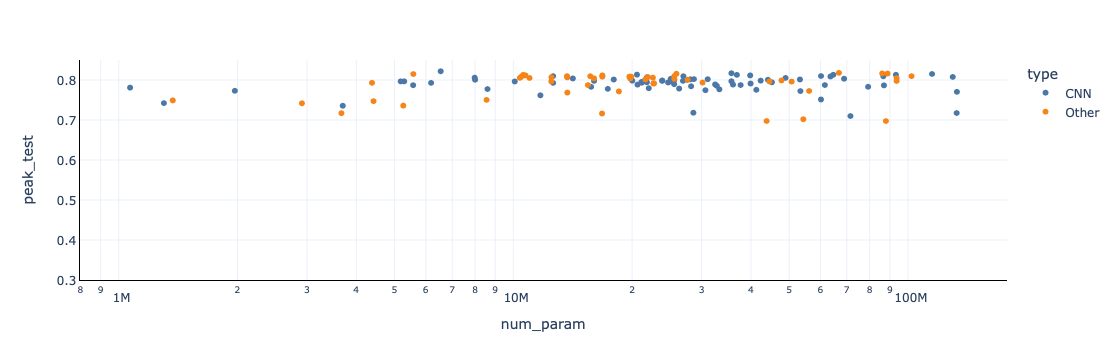

In [132]:
# grouped_df = df.groupby("model")[["peak_test", "num_param"]].mean()
df["relative_peak_test"] = df["peak_test"] / df["dataset_peak_test"]
grouped_df = df.groupby("model").agg({"peak_test": "mean", "relative_peak_test": "mean", "num_param": "mean", "label": "max", "energy": "max", "type": "max"})
px.scatter(grouped_df, x="num_param", y="peak_test", hover_name="label", range_y=[0.3, 0.85], color="type", log_x=True)


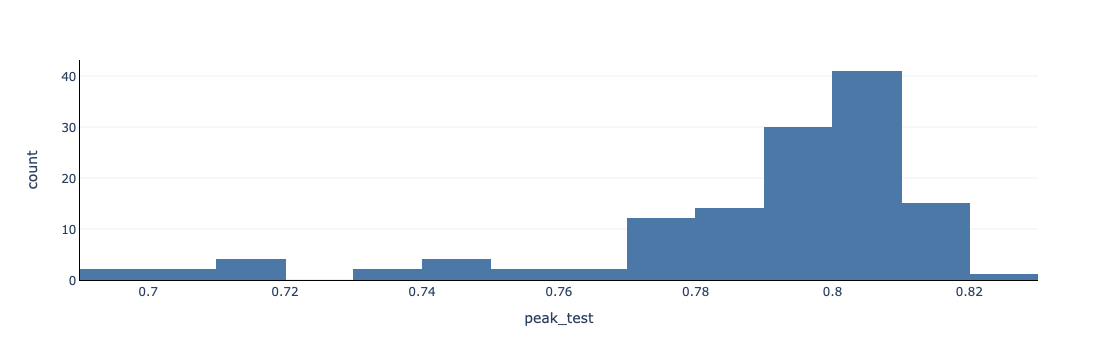

In [133]:
px.histogram(grouped_df, x="peak_test", nbins=16)

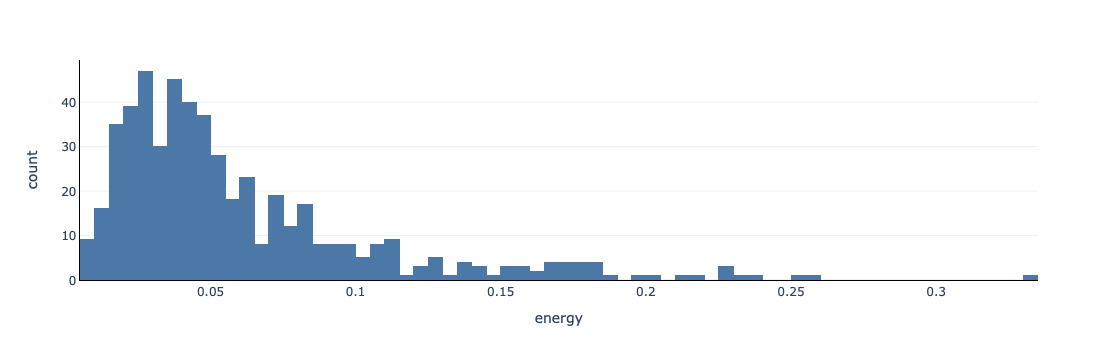

In [134]:
px.histogram(df, x="energy", nbins=2**7)

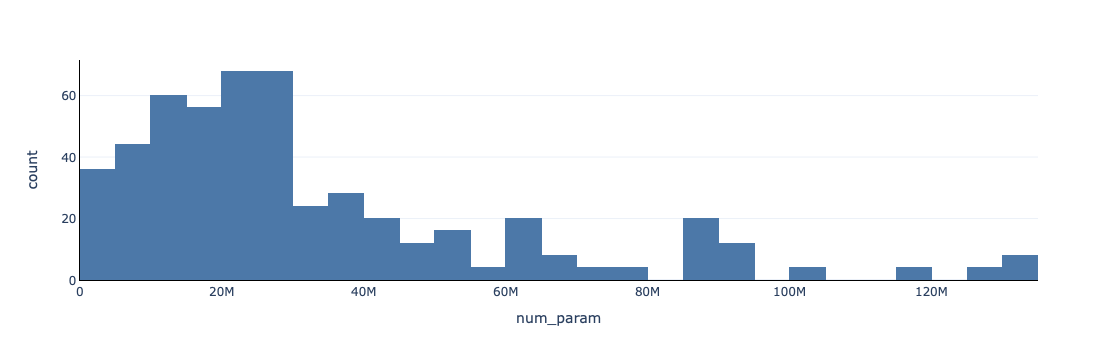

In [135]:
px.histogram(df, x="num_param", nbins=2**6)

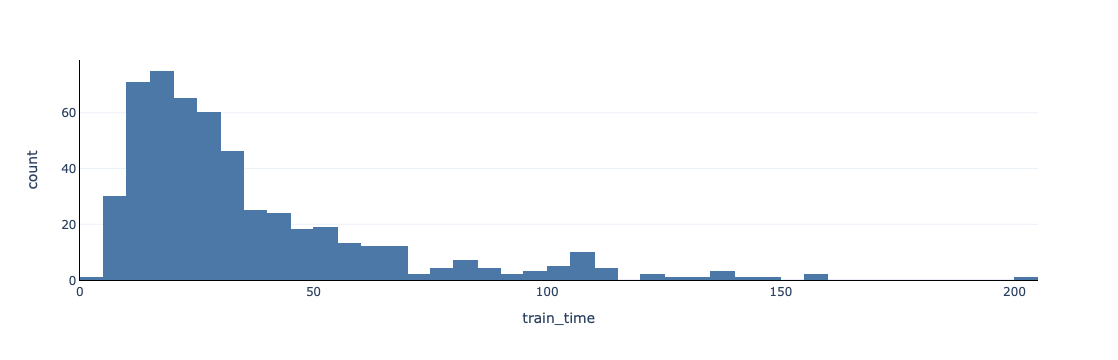

In [138]:
px.histogram(df, x="train_time", nbins=2**6)

In [139]:
resource_column = "E_n"
resource_df = pd.DataFrame(df)
# ressource_column = "energy"
resource_per_epoch = (resource_df[resource_column].values / 10).reshape(-1, 1)
epoch_time = resource_per_epoch * (1+np.arange(10)).reshape(1, -1)
np.max(epoch_time)

0.681212044361209

In [140]:
resource_df["epoch_resources"] = epoch_time.tolist()

In [141]:
sample_times = np.linspace(0, np.max(epoch_time), 2**10)
peak_profile_time = np.zeros((peak_profile.shape[0], sample_times.shape[0]))
for i in range(0, peak_profile.shape[0]):
    peak_profile_time[i] = np.interp(sample_times, epoch_time[i], peak_profile[i])
peak_profile_time

array([[0.66129032, 0.66129032, 0.66276346, ..., 0.73185484, 0.73185484,
        0.73185484],
       [0.59828629, 0.59828629, 0.64163879, ..., 0.7172379 , 0.7172379 ,
        0.7172379 ],
       [0.66481855, 0.66481855, 0.66481855, ..., 0.70766129, 0.70766129,
        0.70766129],
       ...,
       [0.83881579, 0.83881579, 0.83881579, ..., 0.95723684, 0.95723684,
        0.95723684],
       [0.92927632, 0.92927632, 0.92927632, ..., 0.94243421, 0.94243421,
        0.94243421],
       [0.91940789, 0.91940789, 0.91940789, ..., 0.91940789, 0.91940789,
        0.91940789]])

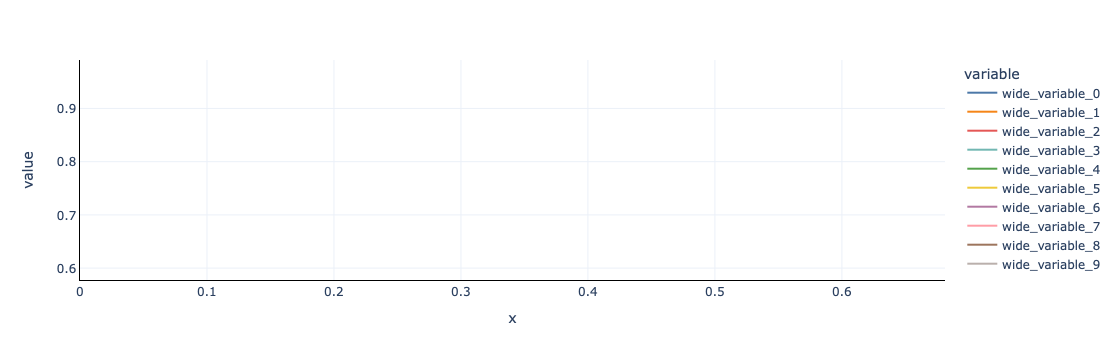

In [142]:
px.line(x=sample_times, y=peak_profile_time[:5].tolist() + peak_profile_time[-5:].tolist())

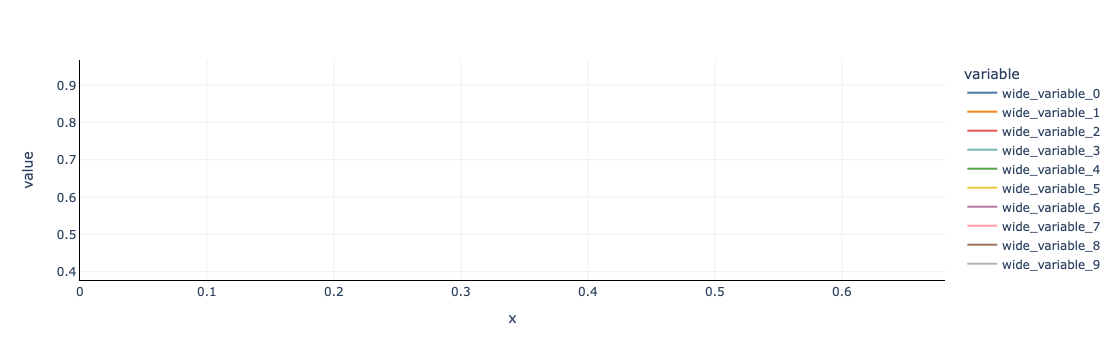

In [143]:
sample_timestep = sample_times[1] - sample_times[0]
normalized_sample_times = (sample_times - sample_timestep) / (np.max(epoch_time) + sample_timestep)
# pepr = peak_profile_time / (1+normalized_sample_times)
pepr = peak_profile_time / (1+sample_times)
px.line(x=sample_times, y=pepr[:5].tolist() + pepr[-5:].tolist())

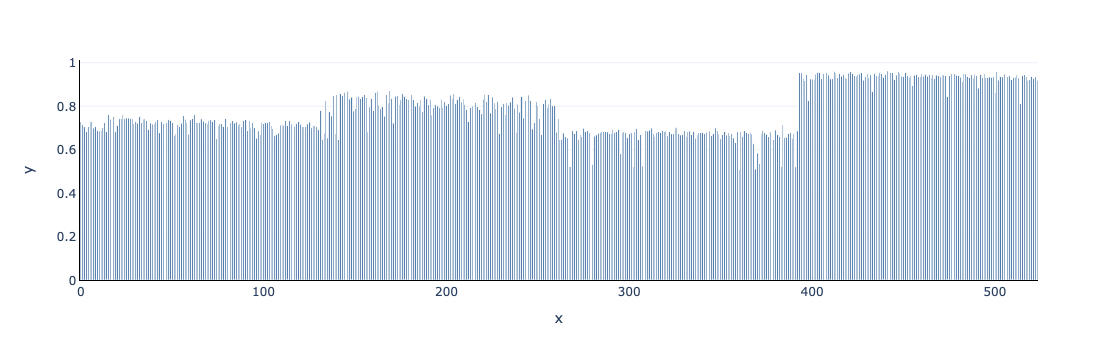

In [144]:
idx = np.argmax(pepr, axis=-1)
r_star = sample_times[idx]
pepr_star = np.array([pepr[i, k] for i, k in enumerate(idx)])
labels = [f"{x.model} {x.dataset}" for x in df.itertuples()]
resource_df["pepr_star"] = pepr_star
px.bar(y=pepr_star, hover_name=labels)
# r_star, pepr_star

In [145]:
rows = []
for x in resource_df.itertuples():
    for epoch, (resource, test) in enumerate(zip(x.epoch_resources, x.peak_profile)):
        peak_epoch = np.argmax(x.peak_profile)
        if epoch > peak_epoch:
            continue
        rows.append({
            "model": x.model, 
            "dataset": x.dataset, 
            "label": f"{x.label} ({epoch})",
            "epoch": epoch+1,
            resource_column: resource, 
            "test": test
        })
epoch_df = pd.DataFrame(rows)
epoch_df

model    dataset                      label  epoch       E_n  \
0        dla46x_c      derma         dla46x_c derma (0)      1  0.000448   
1        dla46x_c      derma         dla46x_c derma (1)      2  0.000896   
2        dla46x_c      derma         dla46x_c derma (2)      3  0.001343   
3        dla46x_c      derma         dla46x_c derma (3)      4  0.001791   
4        dla46x_c      derma         dla46x_c derma (4)      5  0.002239   
...           ...        ...                        ...    ...       ...   
3366  resnetrs270  pneumonia  resnetrs270 pneumonia (3)      4  0.033759   
3367        vgg11  pneumonia        vgg11 pneumonia (0)      1  0.002711   
3368        vgg11  pneumonia        vgg11 pneumonia (1)      2  0.005423   
3369        vgg11  pneumonia        vgg11 pneumonia (2)      3  0.008134   
3370        vgg13  pneumonia        vgg13 pneumonia (0)      1  0.011925   

          test  
0     0.661290  
1     0.661290  
2     0.662802  
3     0.695565  
4     0.695565  
...        ...  
3366  0.957237  
3367  0.929276  
3368  0.929276  
3369  0.942434  
3370  0.919408  

[3371 rows x 6 columns]

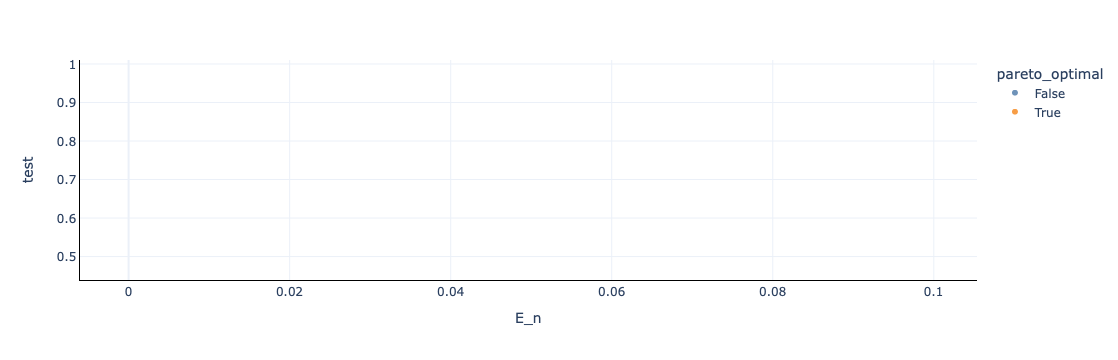

In [146]:
pareto_mask = paretoset.paretoset(epoch_df[["test", resource_column]], sense=["max", "min"])
epoch_df["pareto_optimal"] = pareto_mask
px.scatter(epoch_df, x=resource_column, y="test", color="pareto_optimal", hover_name="label", opacity=0.8)

In [147]:
pareto_df = epoch_df[epoch_df["pareto_optimal"]].sort_values("test", ascending=False).reset_index()
pareto_df = pd.merge(pareto_df, model_df, on="model")
pareto_df = pd.merge(pareto_df, dataset_df, on="dataset")
pareto_df["efficient_label"] = ["Yes" if x else "No" for x in pareto_df["efficient"].values]
pareto_df["small_label"] = ["10%" if x else "Full" for x in pareto_df["small"].values]
# pareto_df["energy_label"] = pareto_df["energy"] * 1000
pareto_df["energy_label"] = [f"{x*1000:.2f}" for x in pareto_df[resource_column]]
pareto_df["num_param_label"] = [f"{(int(x)/1e6):.1f} M" for x in pareto_df["num_param"]]
pareto_df["test_label"] = [f"{x:.3f}" for x in pareto_df["test"]]
pareto_df["epoch_label"] = [f"{x:d}" for x in pareto_df["epoch"]]

table_columns = {
    "model": "Model", 
    "small_label": "Dataset",
    "epoch_label": "Epoch", 
    "num_param_label": "Parameters", 
    "type": "Type",
    "efficient_label": "Efficient",
    "energy_label": "Energy [Wh]", 
    "test_label": "Test Accuracy", 
}
table_df = pareto_df[list(table_columns)].rename(columns=table_columns)
table_df

Model Dataset Epoch Parameters   Type Efficient Energy [Wh]  \
0     poolformer_m36    Full     8     56.2 M  Other        No       13.55   
1       gcresnet33ts    Full     5     19.9 M  Other        No        5.24   
2          fbnetv3_b    Full     3      8.6 M    CNN       Yes        3.66   
3   ese_vovnet19b_dw    Full     3      6.5 M    CNN       Yes        2.99   
4           dla46x_c    Full     8      1.1 M    CNN        No        1.68   
5           dla46x_c    Full     2      1.1 M    CNN        No        0.42   
6       cspresnext50    Full     1     20.6 M    CNN        No        1.02   
7            dla46_c    Full    10      1.3 M    CNN        No        0.95   
8            dla46_c    Full     1      1.3 M    CNN        No        0.10   
9      hardcorenas_a    Full     1      5.3 M  Other       Yes        0.34   
10   mobilenetv2_050    Full    10      2.0 M    CNN       Yes        0.00   

   Test Accuracy  
0          0.972  
1          0.967  
2          0.962  
3          0.959  
4          0.957  
5          0.952  
6          0.956  
7          0.954  
8          0.931  
9          0.938  
10         0.918

In [148]:
print(table_df.to_latex(escape=True, index_names=False))

\begin{tabular}{lllllllll}
\toprule
 & Model & Dataset & Epoch & Parameters & Type & Efficient & Energy [Wh] & Test Accuracy \\
\midrule
0 & poolformer\_m36 & Full & 8 & 56.2 M & Other & No & 13.55 & 0.972 \\
1 & gcresnet33ts & Full & 5 & 19.9 M & Other & No & 5.24 & 0.967 \\
2 & fbnetv3\_b & Full & 3 & 8.6 M & CNN & Yes & 3.66 & 0.962 \\
3 & ese\_vovnet19b\_dw & Full & 3 & 6.5 M & CNN & Yes & 2.99 & 0.959 \\
4 & dla46x\_c & Full & 8 & 1.1 M & CNN & No & 1.68 & 0.957 \\
5 & dla46x\_c & Full & 2 & 1.1 M & CNN & No & 0.42 & 0.952 \\
6 & cspresnext50 & Full & 1 & 20.6 M & CNN & No & 1.02 & 0.956 \\
7 & dla46\_c & Full & 10 & 1.3 M & CNN & No & 0.95 & 0.954 \\
8 & dla46\_c & Full & 1 & 1.3 M & CNN & No & 0.10 & 0.931 \\
9 & hardcorenas\_a & Full & 1 & 5.3 M & Other & Yes & 0.34 & 0.938 \\
10 & mobilenetv2\_050 & Full & 10 & 2.0 M & CNN & Yes & 0.00 & 0.918 \\
\bottomrule
\end{tabular}



In [149]:
frontier_models = pd.DataFrame()
frontier_models["model"] = pareto_df["model"].unique()
frontier_models["pareto_frontier"] = True
frontier_models

model  pareto_frontier
0    poolformer_m36             True
1      gcresnet33ts             True
2         fbnetv3_b             True
3  ese_vovnet19b_dw             True
4          dla46x_c             True
5      cspresnext50             True
6           dla46_c             True
7     hardcorenas_a             True
8   mobilenetv2_050             True

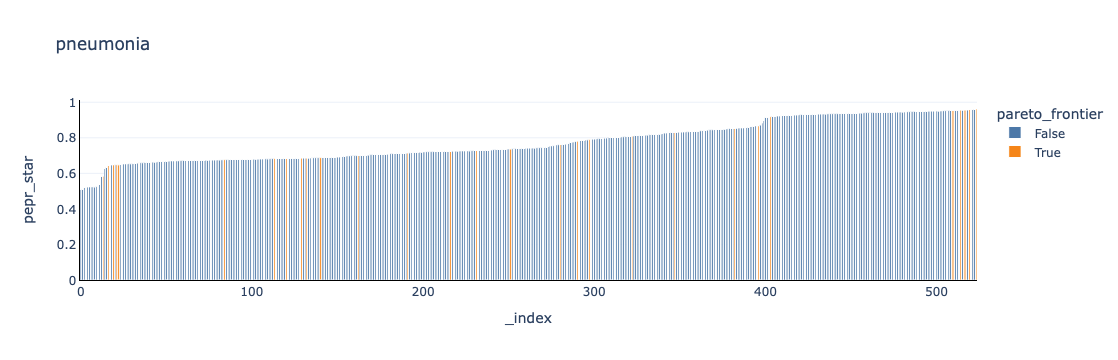

In [150]:
frontier_pepr_df = pd.merge(resource_df, frontier_models, on="model", how="left")
idx = frontier_pepr_df["pareto_frontier"] != True
frontier_pepr_df.loc[idx, "pareto_frontier"] = False
bar_column = "pepr_star"
frontier_pepr_df = frontier_pepr_df.sort_values(bar_column).reset_index()
px.bar(frontier_pepr_df, y=bar_column, color="pareto_frontier", hover_name="label", title=dataset_prefix, category_orders={"pareto_frontier": [False, True]})

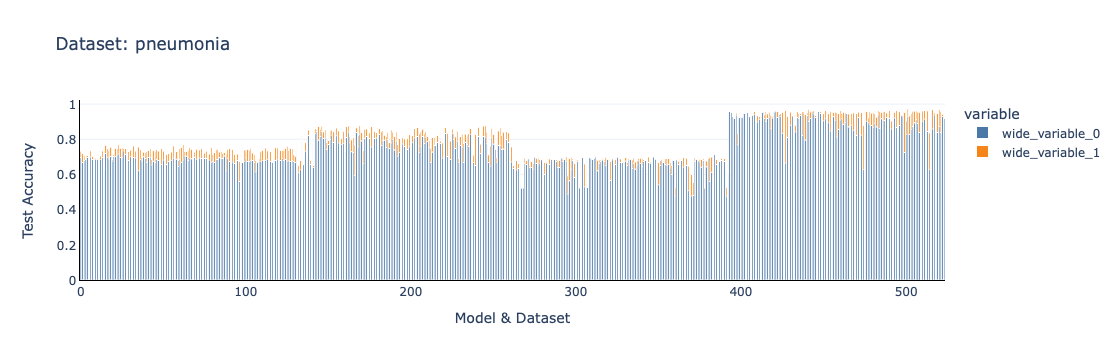

In [151]:
base_idx = 3
labels = [f"{x.model} {x.dataset}" for x in df.itertuples()]
px.bar(y=[peak_profile_time[:, base_idx], peak_profile_time[:, -1]-peak_profile_time[:, base_idx]], 
       hover_name=labels, labels={"index": "Model & Dataset", "value": "Test Accuracy"}, title=f"Dataset: {dataset_prefix}")

In [152]:
stratify_column = "num_param"
quantile_p = np.linspace(0, 1, 6)
quantiles = np.quantile(df[stratify_column].values, quantile_p)
quantiles[-1] += 1e-6
quantile_p, quantiles

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 array([1.06844000e+06, 1.17087440e+07, 2.11102480e+07, 2.76421840e+07,
        5.07215840e+07, 1.33047848e+08]))

In [153]:
# resource_df["model_size"] = ["small" if x.num_param < 30e6 else "large" for x in resource_df.itertuples()]
resource_df["model_size"] = ["small" if x.num_param < 25e6 else "large" for x in resource_df.itertuples()]

In [154]:
def compute_strat_stats(dataset_df, strat_column, value_column):
    strat_dfs = list(dataset_df.groupby(strat_column))
    column_result = {}
    groups = [df[value_column]for _, df in strat_dfs]
    column_result["kruskal_p"] = scipy.stats.kruskal(*groups).pvalue
    column_result["f_oneway_p"] = scipy.stats.f_oneway(*groups).pvalue
    column_result["normality_p"] = {k: scipy.stats.normaltest(df[value_column]).pvalue for k, df in strat_dfs}
    column_result["means"] = {k: df[value_column].mean() for k, df in strat_dfs}
    column_result["medians"] = {k: df[value_column].median() for k, df in strat_dfs}
    column_result["stds"] = {k: df[value_column].std() for k, df in strat_dfs}
    p_values_median = {}
    p_values_mean = {}
    for i, (k_i, df_i) in enumerate(strat_dfs):
        for k_j, df_j in strat_dfs[(i+1):]:
            stat_median = scipy.stats.kruskal(df_i[value_column], df_j[value_column])
            stat_mean = scipy.stats.ttest_ind(df_i[value_column], df_j[value_column], equal_var=False)
            p_values_median[(k_i, k_j)] = stat_median.pvalue
            p_values_mean[(k_i, k_j)] = stat_mean.pvalue
    column_result["mean_p"] = p_values_mean
    column_result["median_p"] = p_values_median
    return column_result

In [155]:
stratification_columns = ["model_size", "type", "efficient"]
value_columns = ["best_test", "pepr_e"]
result = {}
for dataset, dataset_df in resource_df.groupby("dataset"):
    for strat_column in stratification_columns:
        for value_column in value_columns:
            result[(dataset, strat_column, value_column)] = compute_strat_stats(dataset_df, strat_column, value_column)
result

{('derma', 'model_size', 'best_test'): {'kruskal_p': 0.7454817183350917,
  'f_oneway_p': 0.6482496262253599,
  'normality_p': {'large': 0.00026921886808242945,
   'small': 0.10881123464078545},
  'means': {'large': 0.7270626550868485, 'small': 0.7289222873900293},
  'medians': {'large': 0.734375, 'small': 0.7321068548387096},
  'stds': {'large': 0.02275171881144577, 'small': 0.023775056921876016},
  'mean_p': {('large', 'small'): 0.6481393822901025},
  'median_p': {('large', 'small'): 0.7454817183350917}},
 ('derma', 'model_size', 'pepr_e'): {'kruskal_p': 0.0022383923939926845,
  'f_oneway_p': 0.00563970112855735,
  'normality_p': {'large': 7.877231099560802e-13,
   'small': 0.03905439262215196},
  'means': {'large': 0.7057266323780205, 'small': 0.7198631974365793},
  'medians': {'large': 0.7123461048576668, 'small': 0.7236827920333283},
  'stds': {'large': 0.03204067664912142, 'small': 0.025059513102646966},
  'mean_p': {('large', 'small'): 0.005778823775349778},
  'median_p': {('larg

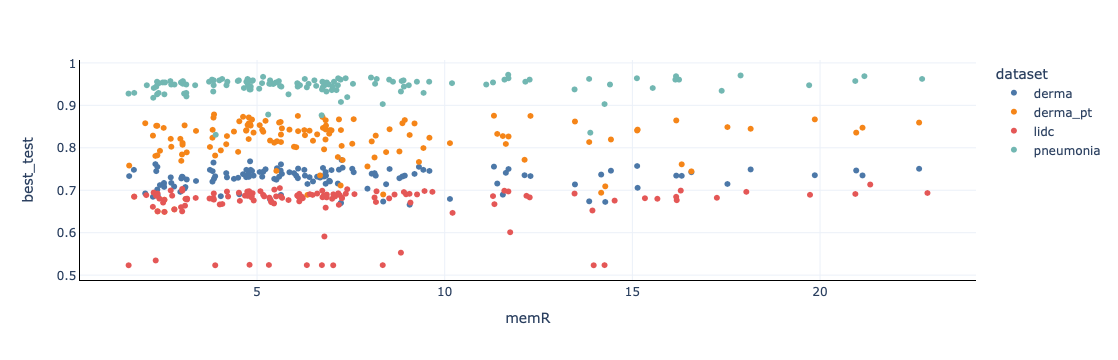

In [176]:
px.scatter(df, x="memR", y="best_test", color=df["dataset"])

In [162]:
dataset_dfs = {k: v for k, v in resource_df.groupby("dataset")}

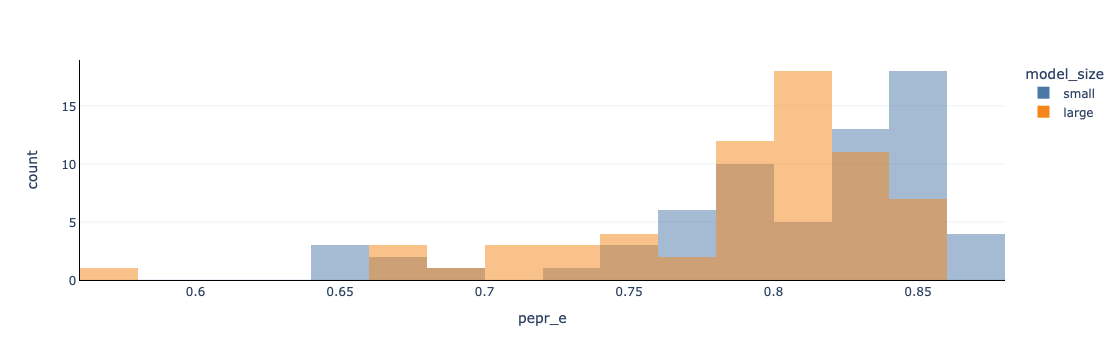

In [167]:
px.histogram(dataset_dfs["derma_pt"], x="pepr_e", color="model_size", barmode="overlay")

In [156]:
significant_results = {k: v for k, v in result.items() if v["kruskal_p"] < 0.05}
significant_results

{('derma', 'model_size', 'pepr_e'): {'kruskal_p': 0.0022383923939926845,
  'f_oneway_p': 0.00563970112855735,
  'normality_p': {'large': 7.877231099560802e-13,
   'small': 0.03905439262215196},
  'means': {'large': 0.7057266323780205, 'small': 0.7198631974365793},
  'medians': {'large': 0.7123461048576668, 'small': 0.7236827920333283},
  'stds': {'large': 0.03204067664912142, 'small': 0.025059513102646966},
  'mean_p': {('large', 'small'): 0.005778823775349778},
  'median_p': {('large', 'small'): 0.0022383923939926845}},
 ('derma', 'type', 'best_test'): {'kruskal_p': 0.0043814832739607215,
  'f_oneway_p': 0.010352125648064215,
  'normality_p': {'CNN': 0.015041473919017294, 'Other': 0.0011518460999327667},
  'means': {'CNN': 0.7238785282258065, 'Other': 0.7344639468690701},
  'medians': {'CNN': 0.7308467741935484, 'Other': 0.7368951612903226},
  'stds': {'CNN': 0.023333113221229666, 'Other': 0.02167191149383028},
  'mean_p': {('CNN', 'Other'): 0.009334951442829394},
  'median_p': {('CNN

In [157]:
rows = []
for (dataset, strat_col, val_col), r in significant_results.items():
    if val_col != "pepr_e" or strat_col != "model_size":
        continue
    rows.append({
        "dataset": dataset,
        "median_small": r["medians"]["small"],
        "median_large": r["medians"]["large"],
        "kruskal_p": r["kruskal_p"],
    })
formatters = {
    "median_small": lambda x: f"{x:.3f}",
    "median_large": lambda x: f"{x:.3f}",
    "kruskal_p": lambda x: f"{x:.3e}"
}
print(pd.DataFrame(rows).to_latex(formatters=formatters, index=False))

\begin{tabular}{lrrr}
\toprule
dataset & median_small & median_large & kruskal_p \\
\midrule
derma & 0.724 & 0.712 & 2.238e-03 \\
derma_pt & 0.825 & 0.805 & 3.874e-02 \\
lidc & 0.657 & 0.626 & 6.255e-04 \\
pneumonia & 0.934 & 0.918 & 1.925e-04 \\
\bottomrule
\end{tabular}



In [158]:
pd.DataFrame(list(significant_results.keys()))

0           1          2
0      derma  model_size     pepr_e
1      derma        type  best_test
2      derma        type     pepr_e
3      derma   efficient  best_test
4   derma_pt  model_size     pepr_e
5   derma_pt   efficient     pepr_e
6       lidc  model_size     pepr_e
7  pneumonia  model_size     pepr_e
8  pneumonia        type  best_test
9  pneumonia   efficient  best_test

In [159]:
value_column = "pepr_star"

In [160]:
resource_df[["pepr_star", "pepr_e"]]

pepr_star    pepr_e
262   0.728459  0.728592
263   0.713910  0.711417
264   0.704378  0.698180
265   0.683111  0.683453
266   0.706318  0.706012
..         ...       ...
519   0.922149  0.899206
520   0.937315  0.825744
521   0.925796  0.882737
522   0.934346  0.917556
523   0.919408  0.821448

[524 rows x 2 columns]

/Users/bob/venv/python3.11/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



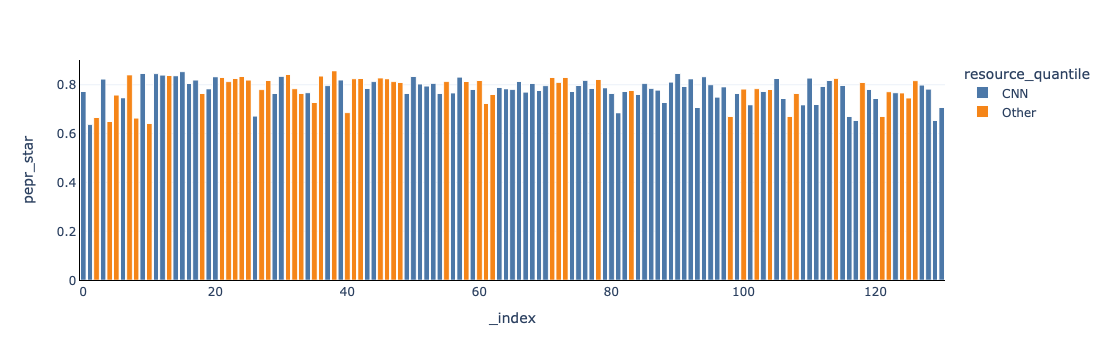

In [253]:
# resource_df["resource_quantile"] = np.searchsorted(quantiles, resource_df[stratify_column].values, side="right")
# resource_df["resource_quantile"] = resource_df["num_param"] < resource_df["num_param"].mean()
# resource_df["resource_quantile"] = resource_df["num_param"] < 30e6
resource_df["resource_quantile"] = resource_df["type"]
px.bar(resource_df.sort_values(stratify_column).reset_index(), y=value_column, color="resource_quantile")

/Users/bob/venv/python3.11/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



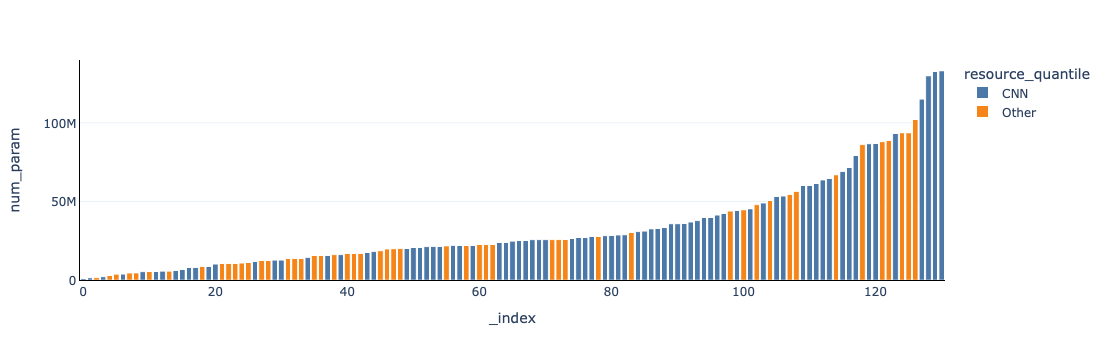

In [254]:
px.bar(resource_df.sort_values(stratify_column).reset_index(), y=stratify_column, color="resource_quantile")

In [255]:
import scipy.stats

In [256]:
scipy.stats.pearsonr(resource_df[stratify_column], resource_df[value_column]), scipy.stats.spearmanr(resource_df[stratify_column], resource_df[value_column])

(PearsonRResult(statistic=-0.23788471032525985, pvalue=0.0062188853942864815),
 SignificanceResult(statistic=-0.26040989655853686, pvalue=0.002664833742425794))

In [257]:
quantile_dfs = list(resource_df.groupby("resource_quantile"))

In [258]:
quantile_indices = [resource_df["resource_quantile"] == k for k in resource_df["resource_quantile"].unique()]
values = resource_df[value_column]
groups = [values[idx] for idx in quantile_indices]
scipy.stats.kruskal(*groups), scipy.stats.f_oneway(*groups)

(KruskalResult(statistic=0.563309656648822, pvalue=0.4529297968495908),
 F_onewayResult(statistic=0.007377251073375377, pvalue=0.9316862935348031))

In [259]:
[scipy.stats.normaltest(df[value_column]) for k, df in quantile_dfs]

[NormaltestResult(statistic=15.78550980989344, pvalue=0.0003734393666161841),
 NormaltestResult(statistic=8.750245703482848, pvalue=0.012586595862227913)]

In [263]:
means = {k: df[value_column].mean() for k, df in quantile_dfs}
medians = {k: df[value_column].median() for k, df in quantile_dfs}
stds = {k: df[value_column].std() for k, df in quantile_dfs}
p_values_median = {}
p_values_mean = {}
for i, (k_i, df_i) in enumerate(quantile_dfs):
    for k_j, df_j in quantile_dfs[(i+1):]:
        stat_median = scipy.stats.kruskal(df_i[value_column], df_j[value_column])
        stat_mean = scipy.stats.ttest_ind(df_i[value_column], df_j[value_column], equal_var=False)
        p_values_median[(k_i, k_j)] = stat_median.pvalue
        p_values_mean[(k_i, k_j)] = stat_mean.pvalue
means, medians, stds, {k: p for k, p in p_values_mean.items() if p < 0.05}, {k: p for k, p in p_values_median.items() if p < 0.05}

({'CNN': 0.7793532773529627, 'Other': 0.7801579262217949},
 {'CNN': 0.784654524125718, 'Other': 0.8092580329833192},
 {'CNN': 0.04764289860703649, 'Other': 0.05887171955114585},
 {},
 {})

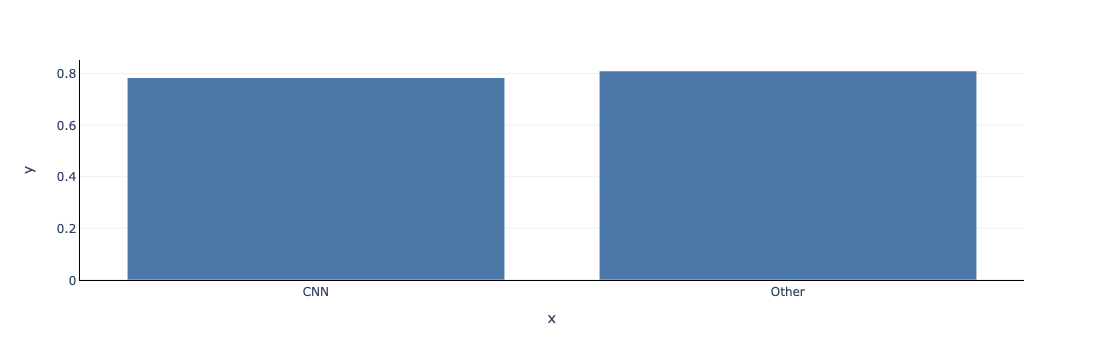

In [262]:
px.bar(x=list(medians.keys()), y=list(medians.values()))

In [ ]:
##

In [490]:
pca = sklearn.decomposition.PCA()
pca_profile = pca.fit_transform(peak_profile_time)
pca.mean_, pca.explained_variance_ratio_

(array([0.67145946, 0.67231504, 0.67317062, ..., 0.72799869, 0.72799913,
        0.72799957]),
 array([9.08545684e-01, 6.46045249e-02, 1.42737910e-02, 5.29648230e-03,
        2.85395610e-03, 1.18078263e-03, 8.60931271e-04, 5.44728941e-04,
        4.94737550e-04, 3.17956975e-04, 2.58947936e-04, 1.41061368e-04,
        1.08778631e-04, 1.03218647e-04, 8.37087362e-05, 7.35432359e-05,
        5.74536235e-05, 3.94136353e-05, 3.15300882e-05, 2.41353115e-05,
        2.02262770e-05, 1.47136864e-05, 1.12344672e-05, 9.25414525e-06,
        7.63053548e-06, 5.46507533e-06, 4.36987037e-06, 4.13554442e-06,
        3.80461346e-06, 3.13638946e-06, 2.91222564e-06, 2.79324795e-06,
        2.47823013e-06, 1.54887065e-06, 1.44187591e-06, 1.22357295e-06,
        9.60772921e-07, 9.21352317e-07, 7.02280202e-07, 6.71059138e-07,
        5.55862259e-07, 5.07468137e-07, 4.42944559e-07, 3.18232548e-07,
        2.78295864e-07, 2.35246192e-07, 2.17471152e-07, 2.01851609e-07,
        1.85627064e-07, 1.66232513e-07, 1

In [401]:
# np.corrcoef(test_profile, rowvar=False)

In [402]:
# np.std(test_profile, axis=1)

/Users/bob/venv/python3.11/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



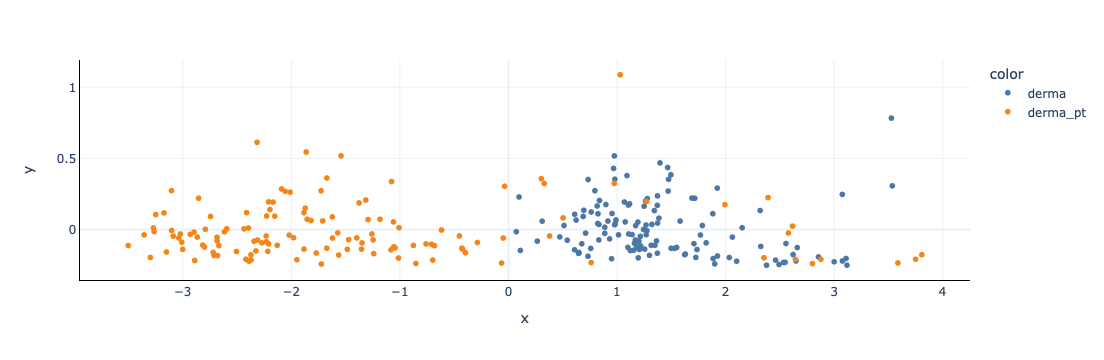

In [403]:
px.scatter(x=pca_profile[:, 0], y=pca_profile[:, 1], hover_name=df["label"], opacity=1.0, color=df["dataset"], color_continuous_scale="RdBu")

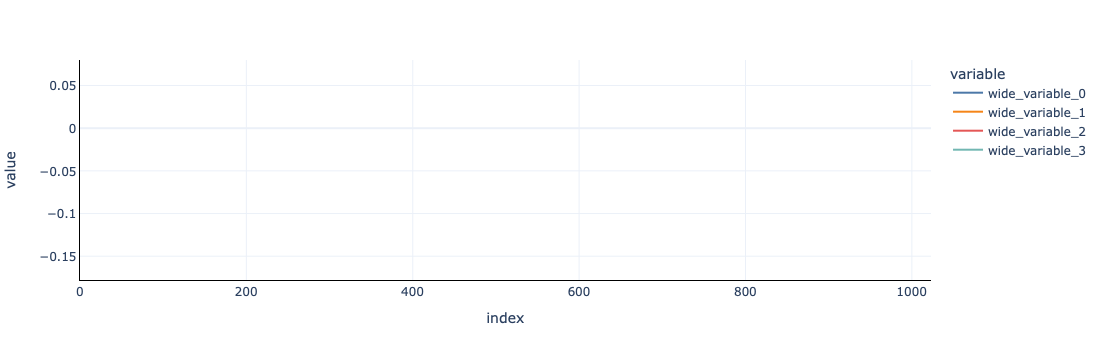

In [404]:
px.line(y=[pca.components_[i] for i in range(4)])